In [ ]:
#pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 719 kB 7.7 MB/s 
     |████████████████████████████████| 5.8 MB 68.3 MB/s 
     |████████████████████████████████| 1.3 MB 68.6 MB/s 
     |████████████████████████████████| 452 kB 58.8 MB/s 
     |████████████████████████████████| 1.6 MB 60.1 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 
     |████████████████████████████████| 132 kB 57.1 MB/s 
     |████████████████████████████████| 213 kB 79.3 MB/s 
     |████████████████████████████████| 127 kB 82.4 MB/s 
     |████████████████████████████████| 7.6 MB 60.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# 이전까지...
from fastai.vision.all import *
from fastbook import *
import ipywidgets as widgets

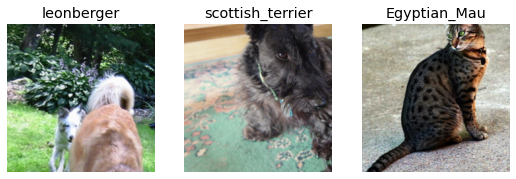

In [ ]:
path= untar_data(URLs.PETS)

pets= DataBlock(blocks= (ImageBlock, CategoryBlock),
                get_items= get_image_files,
                splitter= RandomSplitter(seed= 42),
                get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms= Resize(460),
                batch_tfms= aug_transforms(size=224, min_scale=0.75))
dls= pets.dataloaders(path/"images")

dls.show_batch(nrows=1, ncols=3)

In [ ]:
learn= vision_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.551200,0.333903,0.106225,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.493119,0.305348,0.104871,01:16
1,0.337671,0.219371,0.073072,01:18


In [ ]:
acts= torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
sm_acts= torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

...

# 5.3.3 로그 가능도
##### ( 교차 엔트로피 손실은 '소프트맥스'와 '로그 가능도'로 구성된다. )
#### 4장에서 다룬 MNIST 예에서는 다음 함수로 손실을 계산했다.

In [ ]:
def mnist_loss(inputs, targets):
  inputs= inputs.sigmoid() # 여기 '시그모이드 함수' 사용했었음
  return torch.where(targets==1, 1-inputs, inputs).mean()

#### 5장에서는 "시그모이드에서 소프트맥스로 변경했음"을 기억해야한다.
#### 즉, 이진 분류 이상에서 작동하는 형태로 확장해야한다. 따라서, 범주의 개수와 무관하게 분류할 수 있어야 한다.(범주 37개였던거 기억하기)
#### 그리고, 소프트맥스를 거친 결과값(예측 활성값)은 0 ~ 1 사이이며, 모두 더하면 1이다. 그리고 타깃값은 0과 36사이의 정수이다.
#### 이진 문제에서는 torch.where로 inputs와 1-inputs 사이를 선택했다. 하지만, 이때는 범주가 하나였기 때문에 가능했지만, 이번 5장에서는 범주가 여러개(2개) 즉, inputs와 1-inputs에 대응하는 별도의 행이 존재하기 때문에 훨씬 간단해진다. 따라서, 올바른 행을 선택하기만 하면 된다.
아래는 인위적으로 만든 숫자 3과 7의 레이블이 다음과 같다고 가정한다.

In [ ]:
targ= tensor([0, 1, 0, 1, 1, 0])

#### 위에서 사용했던 소프트맥스를 적용한 결과

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

#### 여기서 텐서의 '색인 기능을' 이용해 targ의 각 요소에 대해 sm_acts의 적절한 열을 선택할 수 있다.

In [ ]:
idx= range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

#### * 3과 7열로 2열 행렬을 구성하고, targ와 idx 열의 값으로 해당 행렬을 색인하면, 마지막 열의 값을 구할 수 있다.
#### ** pytorch는 sm_acts[range(n), targ]와 정학히 같은 일을 하는 nll_loss함수를 제공한다.
##### (단, 음수를 수용한다는 점은 다르다. 그리고, nll은 음의 가능도(negative log likelihood)를 뜻한다.)

In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

#### * nll_loss는 이름과 다르게 "로그를 적용하지 않는다."

# 5.3.4 로그 취하기
#### nll_loss는 손실함수로서 꽤 잘 작동한다. 하지만, 문제가 있는데, 확률값이 0보다 작거나 1보다 클 수 없다는 점이다.
### 따라서, 모델은 예측값이 0.99일 때와 0.999일 때의 차이를 잘 다루지 못한다.
#### 이게 무슨 문제냐 하겠지만, **0.999는 0.99보다 "신뢰도가 10배나 높다"고 해석할 수 있다.**
#### 이를 해결하기 위해 0~1 사이의 값을 **-무한 ~ +무한 으로 변환해야한다.** 그리고, 이를 해결하게 해주는 수학 함수가 바로 **"로그"**이다.

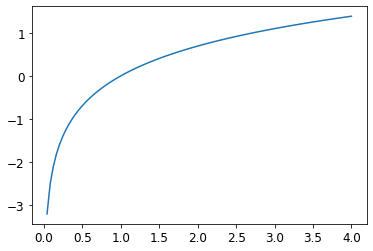

In [ ]:
# 파이토치 제공
plot_function(torch.log, min=0, max=4)

#### 일반적으로 로그는 지수함수의 역수이다.
#### 그리고, 파이토치는 자연상수 e를 밑으로 하는 로그를 제공한다.
#### 로그의 공식중 log(a*b)= log(a)+log(b)를 기억하라.
##### (로그의 메커니즘상, log(a) + log(b)는 e^a * e^b 이다. 결국, 곱셈이라는 소리)
#### 정말 크거나 작은 숫자를 만들 수 있는 **곱셈을 덧셈으로 대체**하여 **컴퓨터가 다루기 쉬운 척도로 변환**해주기 때문에, 많은 공학분야에서 애용한다.
##### (의외로 척척박사같아 보이는 **컴퓨터는 덧셈만 잘한다**)
#### 그럼, 우리는 로그가 왜 필요할까?
### **'확률의 양'** 또는 '음의 로그 평균'으로 **"음의 로그 가능도"**를 얻을 수 있다.
##### * **파이토치의 "nll_loss 함수는 이미 소프트맥스에 로그가 적용되었다고 가정"한다.** 따라서, 로그를 적용하는 과정은 포함되지 않는다.
##### ** nll_loss는 log_softmax(log와 softmax를 결합한 함수) 이후에 사용되도록 설계되어있다.

In [ ]:
# 크로스 엔트로피 손실은 소프트맥스 + 로그가능도
loss_func= nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
# 이렇게도 가능하다! F 네임스페이스에서 사용하기
F.cross_entropy(acts, targ)

tensor(1.8045)

#### 기본적으로 파이토치의 손실함수는 "모든 항목의 평균 손실을 계산"한다.
#### reduction = 'none' 옵션을 사용하면, 이런 행동을 비활성화 할 수 있다.

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

#### 교차 엔트로피 손실의 흥미로운 특징은 그레디언트를 고려할 때 나타난다.
#### cross_entropy(a, b)의 그레디언트는 softmax(a)-b 이다.
#### softmax(a)는 '모델의 최종 활성'이므로, 그레디언트가 "예측과 타깃간의 차이에 비례함"을 의미한다.
#### 그레디언트가 '선형'이기 때문에, 갑작스러운 점프, 기하급수적인 증가가 없어서, 모델은 더 원할히 학습이 가능하다.

# 5.4 모델 해석
### 지금까지, 손실함수 까지 알아보았다. 이제는 우리가 알아낸 지식이 어떻게 적용되는지 알아야하지 않을까?
#### 1장에서 '오차행렬'로 모델이 잘한 부분과 그렇지 못한 부분을 확인했다.

In [ ]:
interp= ClassificationInterpretation.from_learner(learn)

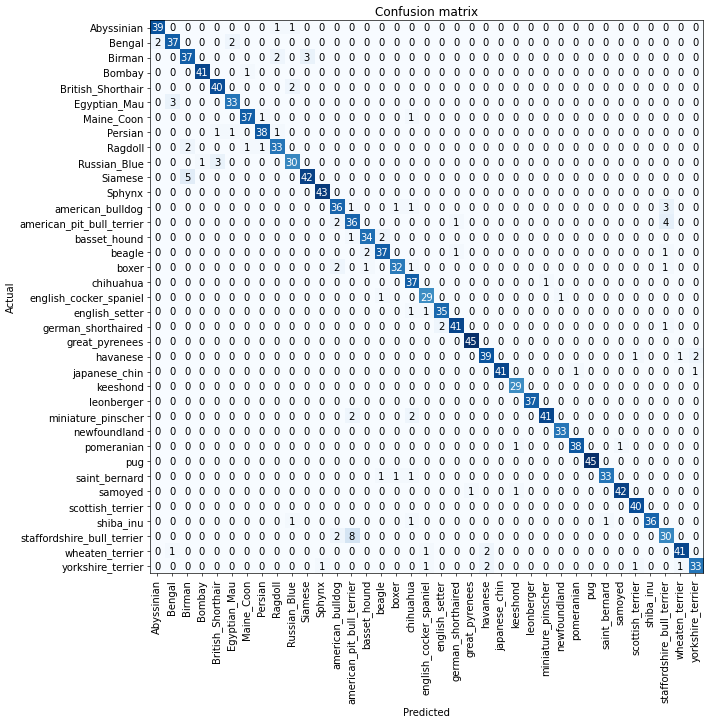

In [ ]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

#### 어... 은근히 읽기 힘들다...
### 이럴때 쓰라고 있는게 'most_confused 메소드' 이다.
#### 가장 올바르지 못한 예측만 보여준다.

In [ ]:
interp.most_confused(min_val=5) # min_val=5는 최소 5번 잘못 에측한 부분만 추출한다는 의미

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Siamese', 'Birman', 5)]

# 5.5 모델 향상하기
#### 모델 학습에서 가장 먼저 건드리는게 무엇일까?
### 바로 '학습률'이다.
#### 4장에서 학습률을 적절히 설정해야 학습이 더 효율적으로 이루어짐을 배웠다. 그렇다면, 어떻게 해야 좋은 학습률을 고를 수 있을까?
#### .
# 5.5.1 학습률 발견자
#### 간단하게 생각해서, "**단순히** 학습률을 **높게** 설정해볼까?"

In [ ]:
learn= vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr= 0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.639349,3.161469,0.341678,01:15


epoch,train_loss,valid_loss,error_rate,time
0,3.916494,6.168392,0.700271,01:19


#### train_loss가 2.63 에서 3.91로 오히려 커지는 것을 볼 수 있다.
### 너무 많이 움직인 것이다.
#### 그렇다면, 어떻게 해야 학습률을 선택할 수 있을까?
### "학습률 발견자" 라는 아이디어가 있다.
#### 방법은 이렇다.
#### (1) 미니배치 하나에 선택된 학습률을 사용하고, 손실을 측정하다.
#### (2) 특정 비율로 학습률을 늘린다(예: 매번 두 배로 늘림).
#### (3) 다음 미니배치에서 증가된 학습률을 적용하고, 손실을 측정한다.
#### (4) 그 다음 학습률을 또 다시 늘린다.
#### (5) 손실이 나빠지기 직전까지 이를 반복한다.
### 좋은 아이디어이다. 그렇다면, 일반적으로 학습률을 선택하는 방법은 뭐가 있을까? 2가지 규칙이 있다.
#### 1. 최소 손실이 발생한 지점보다 한 자릿수 작은 학습률(예: 최소 손실이 발생한 학습률을 10으로 나눈값)
#### 2. 손실이 명확히 감소하는 마지막 지점
### 참고로, fastai는 디폴트 값으로 1e-3을 제시한다.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


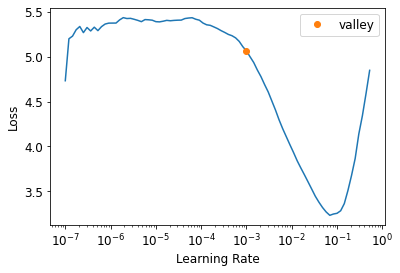

In [ ]:
learn= vision_learner(dls, resnet34, metrics=error_rate)
lr_find= learn.lr_find() # 학습률 발견자

#### 그래프를 보았을 때, 1e-6과 1e-3 구간에서는 별다른 사건이 발생하지 않았다.
#### 1e-3을 지날때는 가파르게 감소하기 시작해, 최하점에 도달하고 있다.
#### 거의 1e-1에서부터 다시 증가하기 시작한다. 따라서, 학습을 이탈시킬 가능성이 높은 1e-1보다 큰 학습률은 바람직하지 않다.
##### (참고로, 1e-1도 상당히 큰 값이다.)
### 그래프를 보고 생각해봤을 때, 3e-3 부근의 학습률이 적당해 보인다.

In [ ]:
learn= vision_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2, base_lr=3e-3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.289690,0.367467,0.113667,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.555217,0.442817,0.126522,01:31
1,0.355139,0.246548,0.079161,01:24


### 위의 도표는 **"로그 척도(log scale)"**로 그려졌다.
#### 1e-3과 1e-2의 중간점이 3e-3과 4e-3 사이인 이유이다.
#### **학습률에서는 주로 자릿수에 관심을 두기 때문에** 보통 로그 척도가 사용된다.

# 5.5.2 동결 해제 및 전이 학습
### 지금까지, 우리는 fine_tune만을 해왔다. 하지만, 이번에는 전이학습을 다뤄보도록 하자.
#### 내용을 진행하기 전에, 우리가 기억해야하는 것들을 말해보자면
#### 합성곱 신경망은 (1) 여러 선형 계층과 이들을 잇는 비선형 계층의 조합이라는 것.
#### (2) 계층 조합의 끝에는 하나 이상의 선형 계층이 위치한다는 것.
#### (3) 가장 마지막 선형 계층에는 '소프트맥스' 같은 '활성화 함수'가 쓰인다는 것. 또한, 모델이 분류하는 범주의 개수와 열의 크기가 같은 행렬을 사용한다는 것.
### 자, 그런데, '마지막 선형 계층'을 살짝 다시 생각해보자.
#### 사실, **마지막 선형 계층이 전이 학습의 미세 조정에 사용될 가능성은 낮다.** 사전 학습된 원본 데이터셋이 특정한 범주를 분류하도록 디자인되었기 때문이다.
### 따라서, 전이 학습에서는 "이 **(마지막) 계층을 모델 구조에서 제거**하고, 새로운 문제에 맞는 출력 개수로 구성한 **'새로운' 선형 계층으로 교체**해야만한다."
##### (단순하게, 우리는 애완동물(개, 고양이) 품종 37종을 분류해야한다.)

### 새로 추가된 선형 계층의 가중치는 완전 임의로 지정된다.
#### 따라서, 미세 조정 전까지 모델은 완전히 임의의 값을 출력한다.
##### (그렇다고, 모델 자체가 완전히 임의적이라는 뜻은 아니다.)
### 잠시 1장을 생각해보자,(p.69-70)
#### 처음 계층 몇 개는 음영, 모서리 같은 일반적인 개념을 인코딩 했다.
#### 이후 계층들 또한 특정 상황에 구체적이긴 하지만, 털, 안구 같이 여전히 우리가 다루는 문제에 유용한 개념을 인코딩했다.
### 따라서,
#### 이렇게 사전 학습된 모델의 유용한 개념을 **"모두 기억한 채"** 새로운 문제를 해결할 모델을 학습시킨다면 가장 바람직할 것이다.
#### 그렇다면, 신중하게 사전 학습된 가중치를 **"망가뜨리지 않으면서"**, 추가된 선형 계층의 **"임의 가중치'를 '새로운 작업을 올바르게 푸는 가중치로 바꿀 수 있을까"**?
### 간단하게 가능하다!
#### 옵티마이저는 추가된 계층의 임의 가중치만 갱신하고, 그 외의 가중치는 전혀 바꾸지 않도록 강제할 수 있다.
### 이를 "동결(freezing)"시키는 기법"이라고 한다.
### 잠시, fine_tune 메소드를 다시 살펴보자면(learn.fine_tune??)
#### 두 작업을 수행한다.
#### 1) 한 에포크 동안 추가된 계층의 임의 가중치만 갱신(학습)한다. 그 외 계층은 동결 상태를 유지한다.
#### 2) 그 다음, 모든 계층의 동결을 해제하고, 요청된 에포크 수만큼 학습을 진행한다.


### fine_tune이 하는 일을 직접 해보도록 하자.

In [ ]:
learn= vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.192507,0.339196,0.108254,01:22
1,0.561684,0.247761,0.074425,01:21
2,0.320319,0.243628,0.075778,01:13


#### 우선 'fit_one_cycle 메소드'로 추가된 계층에 대해 3번의 에포크동안 학습을 수행한다.(fine_tune 과정(1))
#### 그리고 fit_one_cycle 메소드는 fine_tune을 사용하지 않는 상황에서 모델 학습에 권장되는 메소드이다.
##### (참고로, 1장에서도 사용한 적이 있다.)
#### fit_one_cycle 메소드는 전체 학습을 두 부분으로 나눈다.
#### 1) 낮은 학습률로 시작하여, 첫 번째 부분까지 점진적으로 학습률을 증가 시킨다.
#### 2) 두 번째 부분에서는 다시 점진적으로 학습률을 감소시킨다.
### 그리고, 모델의 동결을 해제해 보도록하자.(fine_tune 과정(2))

In [36]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

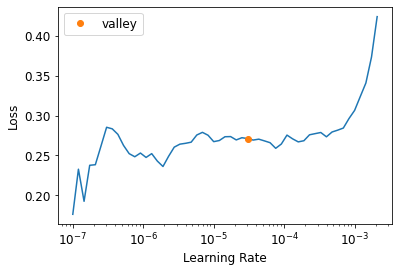

In [37]:
# 다시 한번 학습률 발견!
learn.lr_find()

### 이전과는 그래프가 다르다. 모델이 학습중임을 나타내는 '가파른 절벽'이 '없다'.
#### 모델이 이미 학습되었기 때문이다.
### 이럴때는, 가파르게 상승하는 지점 바로 이전 중에 선택해야한다.(예를 들면, 1e-5 ?)

In [38]:
learn.fit_one_cycle(6, lr_max= 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.249914,0.234222,0.075101,01:29
1,0.245275,0.231570,0.070365,01:26
2,0.213216,0.213422,0.066306,01:18
3,0.204011,0.210715,0.067659,01:16
4,0.204221,0.206023,0.066982,01:17
5,0.189339,0.207545,0.063599,01:16


#### 이로써, 모델을 약간 개선할 수 있었다.
### 막간의 이야기로, "사전 학습된 모델의 가장 심층부에는 '마지막에 추가된 계층의 정도'로 높은 학습률이 필요 없을지도 모른다".
### 즉, '서로 다른 계층'에 '서로 다른 학습률'을 사용해야 할 가능성이 높다는 의미이다. 이를 "**차별적 학습률**(discriminative learning rates)"이라고 한다.